# ACOM Tutorial Notebook 02


This notebook demonstates automated crystal orientation mapping (ACOM) mapping of a simulated 4D-STEM dataset of a nanocrystalline Au sample.

## Data
This is a simulated 4D-STEM dataset.  Simulations were performed by Colin Ophus, have DOI number 10.5281/zenodo.3592520, and can be [downloaded here](https://drive.google.com/file/d/1QiH7phMR0AaMkYoio3uhgTTQMOHG4l6b/view?usp=sharing).  
You should then set the `filepath` variable in the cell below.

## Acknowlegements

This tutorial was made by Alex Rakowski, Benjamin Savitzky, Colin Ophus, and Steven Zeltmann.

### Versioning

Last updated on 2021-09-26 with py4DSTEM v.0.12.6.

In [1]:
import numpy as np
import py4DSTEM

# Load the data

If you are running in binder run the cell below, otherwise skip

In [2]:
# from py4DSTEM.io import download_file_from_google_drive
# download_file_from_google_drive("1QiH7phMR0AaMkYoio3uhgTTQMOHG4l6b", "/home/jovyan/data/calibrationData_simulatedAuNanoplatelet_binned.h5")

In [3]:
# Note - change the file path to your own local path
# filepath = "calibrationData_simulatedAuNanoplatelet_binned.h5"
# filepath = '/media/cophus/DATA/4DSTEM/datasets/calibrationData_simulatedAuNanoplatelet_binned.h5'
# filepath = 'C:/data/4DSTEM/calibrationData_simulatedAuNanoplatelet_binned.h5'
# filepath = '/home/jovyan/data/calibrationData_simulatedAuNanoplatelet_binned.h5'
filepath = "/Users/Ben/Work/Data/py4DSTEM_sampleData/calibration_simulatedAuNanoplatelet/calibrationData_simulatedAuNanoplatelet_binned.h5"

In [4]:
# Check the file contents
py4DSTEM.io.read(filepath)

py4DSTEM file version 0.11.10
Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DataCube          (100, 84, 125, 125)     polyAu_4DSTEM                                         
  1       DataCube          (100, 84, 125, 125)     simulation_4DSTEM                                     
  2       DiffractionSlice  (512, 512)              defocused_probe                                       
  3       DiffractionSlice  (125, 125)              probe_template                                        


In [5]:
# load the data
datacube = py4DSTEM.io.read(filepath,data_id='polyAu_4DSTEM')
probe_image = py4DSTEM.io.read(filepath,data_id='probe_template').data
defocused_probe = py4DSTEM.io.read(filepath,data_id='defocused_probe').data
datacube_rotation = py4DSTEM.io.read(filepath,data_id='simulation_4DSTEM')

# small dataset for testing
#datacube.crop_data_real(0,10,0,10)

# Examine `datacube`

In [6]:
datacube.data.shape

(100, 84, 125, 125)

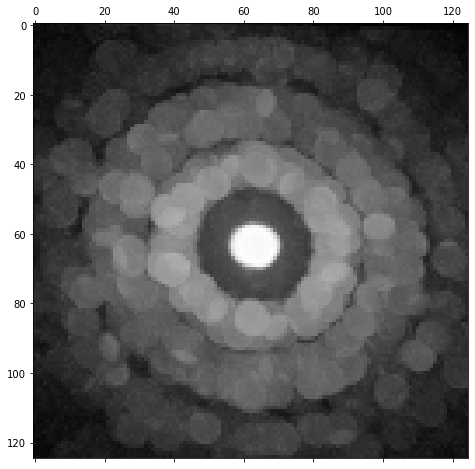

In [7]:
# Examine the 4D calibration dataset by taking a maximum diffraction pattern

datacube.get_max_dp()
datacube.show()

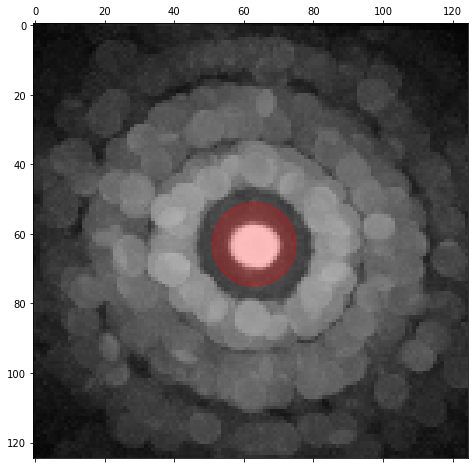

In [8]:
# Position a detector for a bright-field image

center = 63,63
radius = 12

datacube.position_circular_detector(center,radius,datacube.images['dp_max'],scaling='log')

100%|█████████████████████████████████████████████████████████████████████| 8400/8400 [00:00<00:00, 66404.72it/s]


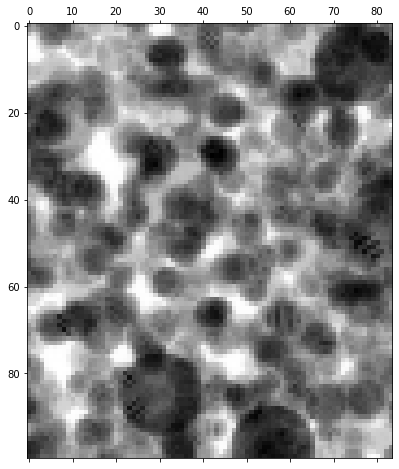

In [9]:
# capture and show the bright field image

datacube.capture_circular_detector(center,radius,'BF')
datacube.show('BF',scaling='none')

# Find the Origin in Diffraction Space

Finding origins: 100%|███████████████████████████████████████████████████████| 8.40k/8.40k [00:13<00:00, 646DP/s]


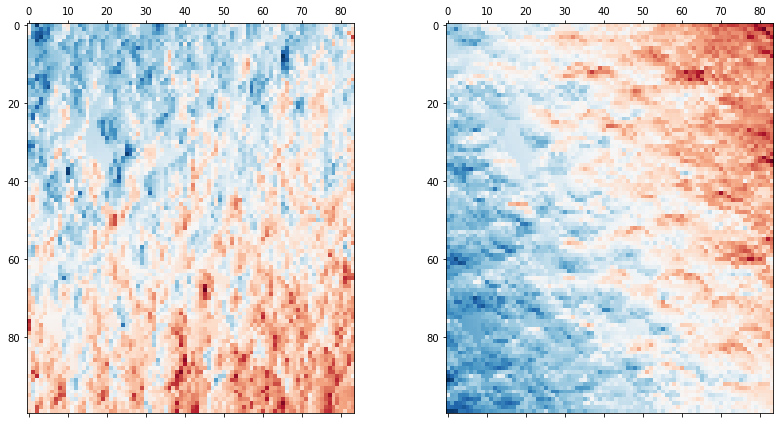

In [10]:
# Find CoM of center disk

datacube.measure_origin()
datacube.show_origin_meas()

Note how the qx0 and qy0 diffraction shifts both change as a function of probe position x and y - this is diffraction shift, or "descan" of the diffraction space images.

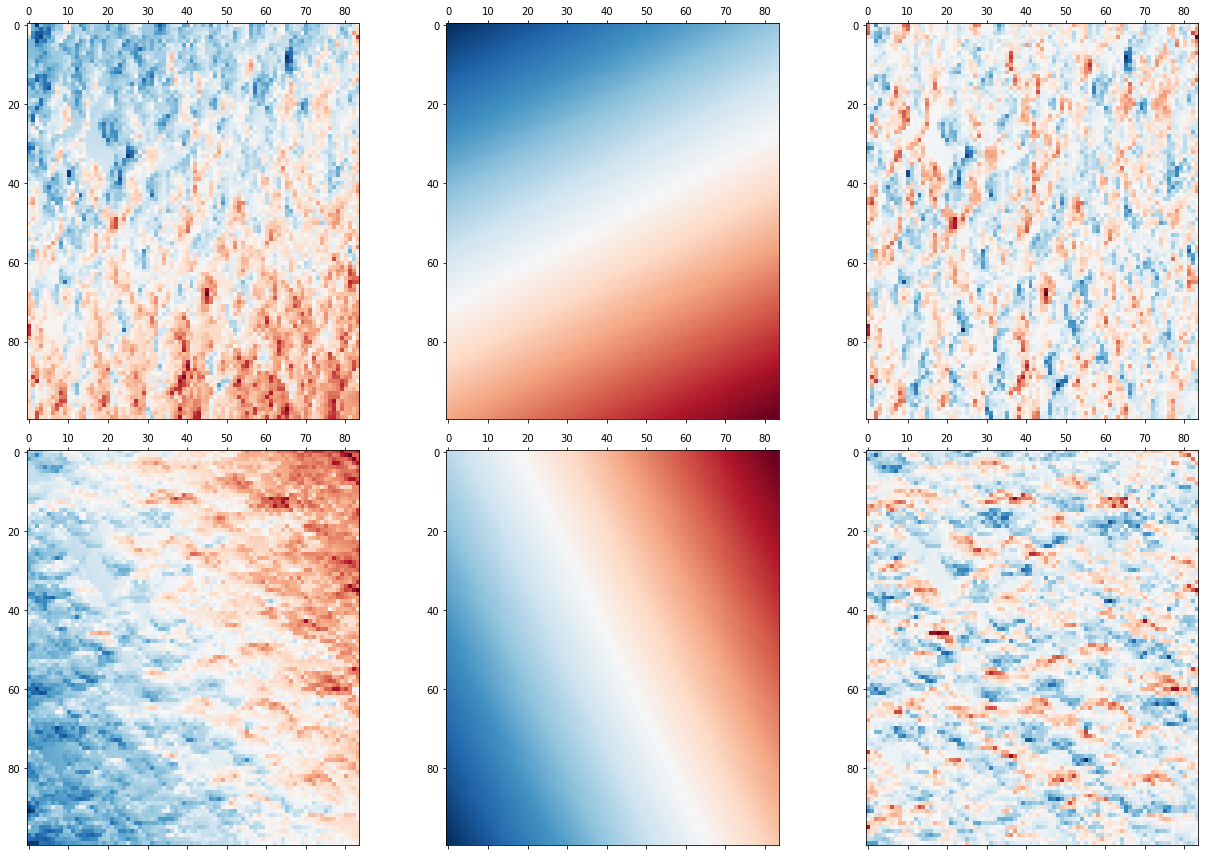

In [11]:
# Fit a plane to qx0 and qy0 with robust fitting

datacube.fit_origin()
datacube.show_origin_fit()

# Prepare the probe

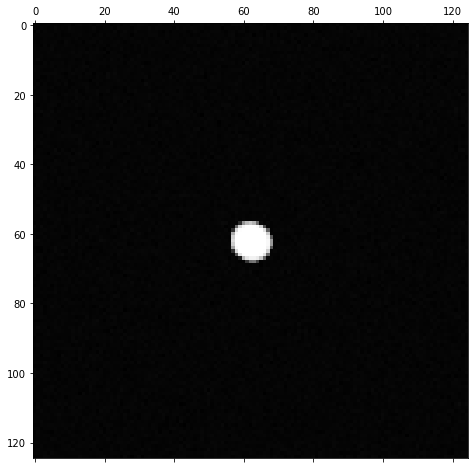

In [12]:
# Attach the probe image to the dataset

datacube.add_probe_image(probe_image)
datacube.show('probe_image')

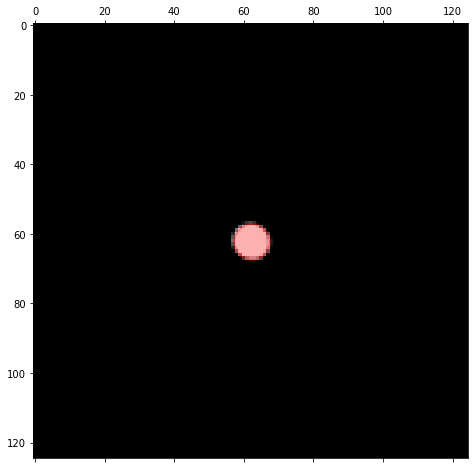

In [13]:
# Measure the probe size

datacube.get_probe_size()
datacube.show_probe_size()

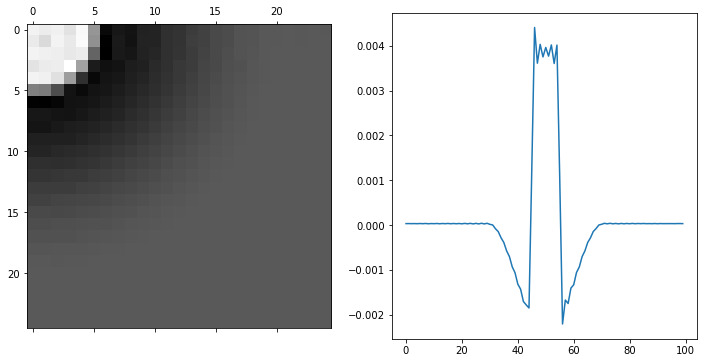

In [14]:
# Prepare the probe kernel

datacube.get_probe_kernel(method='sigmoid',
                          ri=0,
                          ro=datacube.coordinates.alpha_pix * 4)
datacube.show_probe_kernel()

# Locate bragg disks

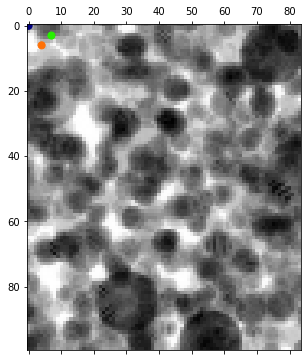

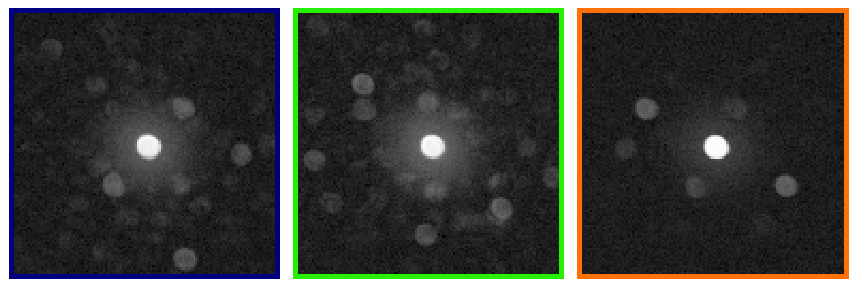

In [15]:
# Select a few DPs on which to test disk detection parameters

# positions = ((24,5),
#              (90,26),
#              (50,76))
positions = ((0,0),
             (3,7),
             (6,4))

datacube.show_selected_dps(positions)

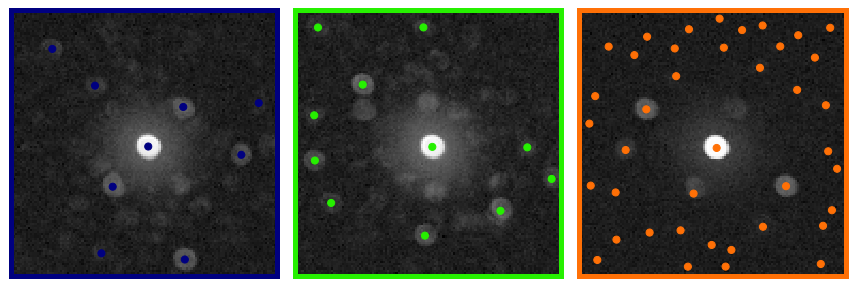

In [16]:
# Tune disk detection parameters on selected DPs

disk_detec_params = {
    'corrPower':1.0,
    'sigma':1,
    'edgeBoundary':4,
    'minAbsoluteIntensity':15.0,
    'minRelativeIntensity':0.0,
    'minPeakSpacing':8,
    'maxNumPeaks':40,
    'subpixel':'poly',
    'upsample_factor':16
}

datacube.find_some_bragg_disks(positions,**disk_detec_params)
datacube.show_some_bragg_disks()

In [17]:
datacube.find_bragg_disks(**disk_detec_params)

Finding Bragg Disks: 100%|███████████████████████████████████████████████████| 8.40k/8.40k [00:35<00:00, 236DP/s]


Calibrating origin positions


Computing Bragg vector map: 100%|████████████████████████████████████████████| 8.40k/8.40k [00:10<00:00, 826DP/s]


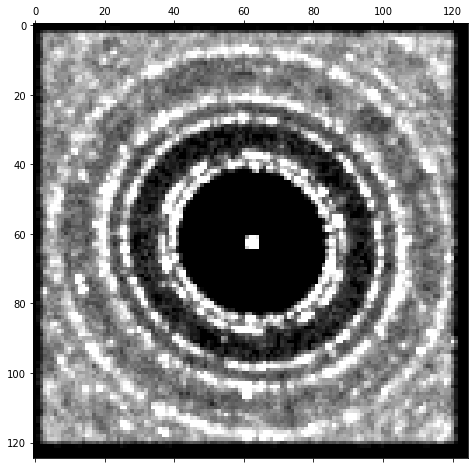

In [18]:
datacube.get_bvm()
datacube.set_bvm_vis_params(cmap='gray',scaling='power',power=0.5,clipvals='manual',min=0,max=500)
datacube.show_bvm()

# Elliptical distortion calibration

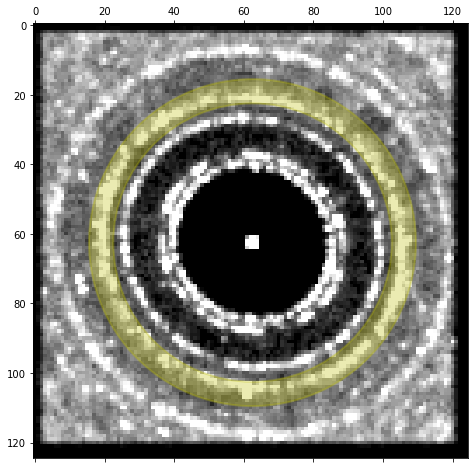

In [19]:
# Select fitting region

fitradii = 40,47
datacube.bvm_fit_select_radii(fitradii)

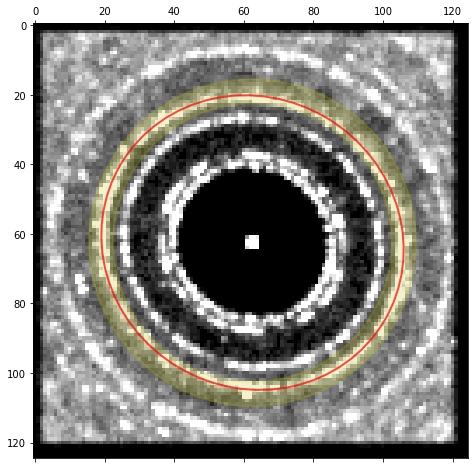

In [20]:
# Fit the elliptical distortions

p_ellipse = datacube.fit_elliptical_distortions_bragg(fitradii)
datacube.show_elliptical_fit_bragg(fitradii,p_ellipse)

In [21]:
# Correct the peak positions

datacube.calibrate_bragg_elliptical_distortions(p_ellipse)

Computing Bragg vector map: 100%|████████████████████████████████████████████| 8.40k/8.40k [00:10<00:00, 813DP/s]


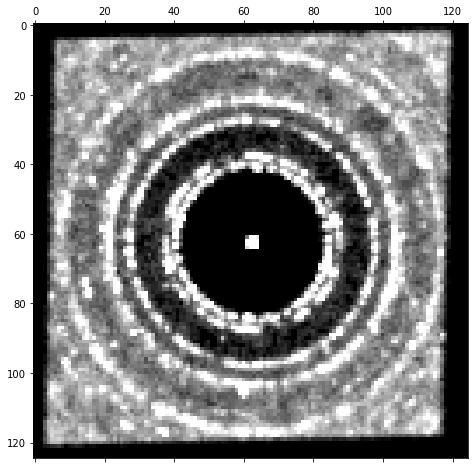

In [22]:
# compute and show the new bvm

datacube.get_bvm()
datacube.show_bvm()

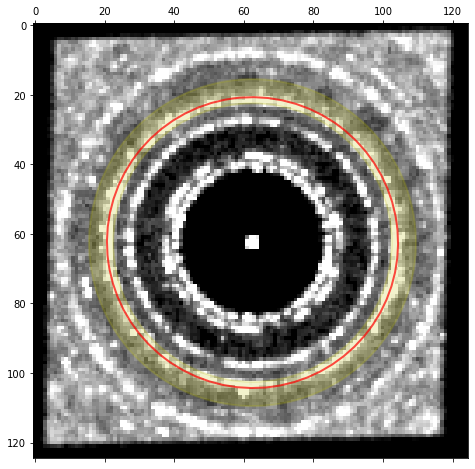

Measured ratios of semiminor to semimajor axes

	 Original data: 	94.65%
	Corrected data: 	99.73%.


In [23]:
# Measure remaining elliptical distortions

p_ellipse_corr = datacube.fit_elliptical_distortions_bragg(fitradii,name='bvm_ellipse')
datacube.show_elliptical_fit_bragg(fitradii,p_ellipse_corr,name='bvm_ellipse')

print("Measured ratios of semiminor to semimajor axes")
print("")
print("\t Original data: \t{:.2f}%".format(100*(p_ellipse[3]/p_ellipse[2])))
print("\tCorrected data: \t{:.2f}%.".format(100*p_ellipse_corr[3]/p_ellipse_corr[2]))

# Pixel size calibration

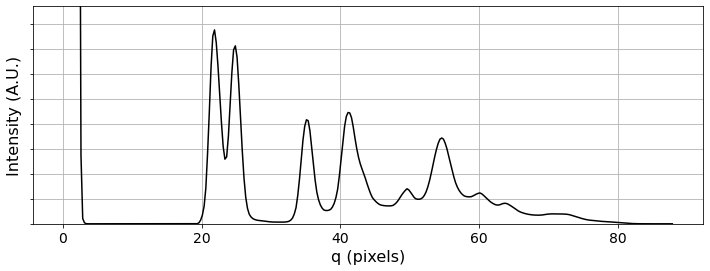

In [24]:
datacube.get_bvm_radial_integral()
datacube.show_bvm_radial_integral()

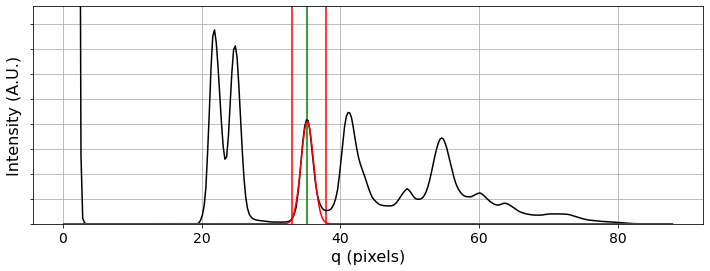

In [25]:
# Fit a peak

qlims = 33,38
q_fit = datacube.fit_bvm_radial_peak(qlims)

In [26]:
# Calibrate detector pixels

datacube.calibrate_dq(q_pix=q_fit,q_known=1.442,units='A')

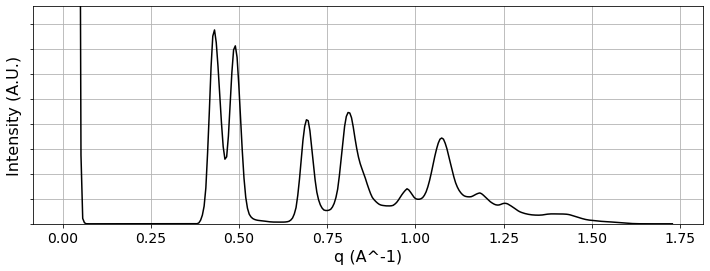

In [27]:
datacube.show_bvm_radial_integral()

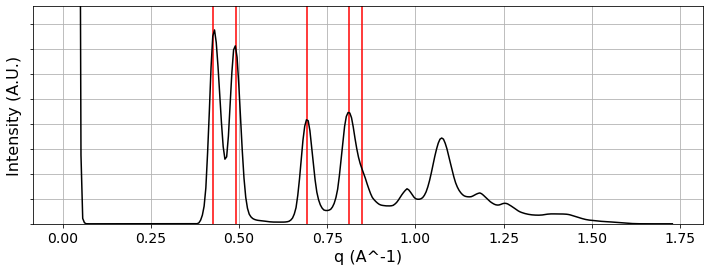

In [28]:
# Demonstrate consistency with known Au spacings

spacings_Ang = np.array([1.177,1.23,1.442,2.039,2.355])   # 222, 113, 022, 002, 111
spacings_inv_Ang = 1./spacings_Ang

datacube.show_bvm_radial_integral(q_ref=spacings_inv_Ang)

In [29]:
datacube.calibrate_bragg_dq()

100%|████████████████████████████████████████████████████████████████████| 8400/8400 [00:00<00:00, 112865.69it/s]


# Rotation Calibration

Often the STEM probe scan coils are rotated with respect to the image direction.  It's best to calibrate this rotation using a shadow image in diffraction space. Alternatively, we can use DPC or pseudo-DPC rotation alignment.  Here we will use the shadow image method.

# Rotation Calibration from DPC

In [30]:
# Calculate the center of mass for all probe positions
CoMx, CoMy = py4DSTEM.process.dpc.get_CoM_images(datacube, mask=1)

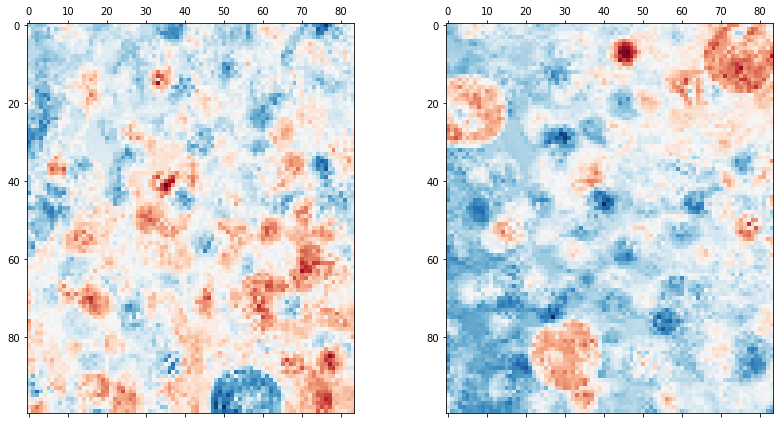

In [31]:
# Plot the 2 CoM outputs, the x and y directions
py4DSTEM.visualize.show_image_grid(
    lambda i:[CoMx, CoMy][i],
    H=1,
    W=2,
    cmap='RdBu')

In [32]:
# Use one of the py4DSTEM DPC algorithms to check for:
# 1 - rotation offset between real and diffraction space coordinates
# 2 - a flip / transpose of the two spaces
theta, flip =  py4DSTEM.process.dpc.get_rotation_and_flip_maxcontrast(CoMx, CoMy, 360)

# Solve for minimum rotation from (-pi,pi) radian range
theta = np.mod(theta + np.pi, 2*np.pi) - np.pi
theta_deg = theta*180/np.pi

# Print the results
print('Image flip detected =', flip);
print('Best fit rotation = ', '%.4f' % theta_deg, 'degrees')

Analyzing: |**************************************************| 100.0% Complete.

Image flip detected = False
Best fit rotation =  86.2396 degrees


In [33]:
datacube.calibrate_rotation(theta,flip)
datacube.calibrate_bragg_rotation()

100%|█████████████████████████████████████████████████████████████████████| 8400/8400 [00:00<00:00, 47070.97it/s]


# Automated Crystal Orientation Mapping

First, we define our Crystal object. This can be done using:
* Manual entry of the lattice and basis
* By loading a CIF file
* By connecting to the Materials Project API (requires that an API key be set in the user's configuration file. See `crystal.py` documentation for details

In [34]:
# Define gold structure
pos = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.5, 0.5],
    [0.5, 0.0, 0.5],
    [0.5, 0.5, 0.0],
])
atom_num = 79
a = 4.08
cell = a

Au = py4DSTEM.process.diffraction.Crystal(
    pos, 
    atom_num, 
    cell)

In [35]:
datacube.get_bvm_radial_integral()


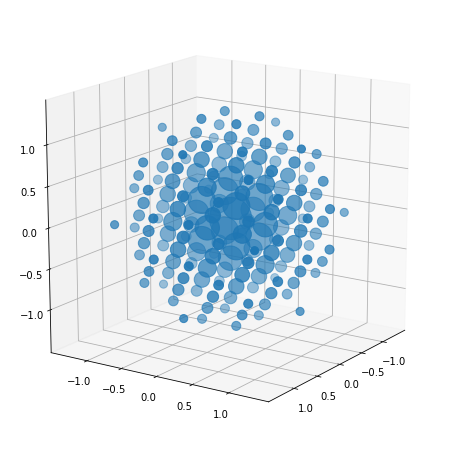

In [36]:
# Calculate and plot gold structure factors
k_max = 1.4
q_SF, I_SF = Au.calculate_structure_factors(k_max, return_intensities=True)
Au.plot_structure_factors(proj_dir=[3, 2, 1])

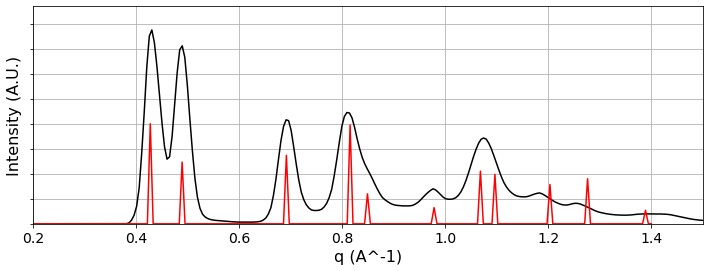

In [42]:
# Compare the structure factors calculated from the structure to the calibrated diffraction intensity to confirm the pixel size calibration is correct

fig, ax = datacube.show_bvm_radial_integral(returnfig=True)

ax.set_xlim([0.2, 1.5])
ax.plot(q_SF, I_SF * 100000, c="r")

In [43]:
# Create an orientation plan for gold
Au.orientation_plan(
    angle_step_zone_axis=3.0,
    angle_step_in_plane=2.0,
    accel_voltage=300e3,
    corr_kernel_size=0.08,
)

Orientation plan: 100%|███████████████████████████████████████████████| 190/190 [00:01<00:00, 160.19 zone axes/s]


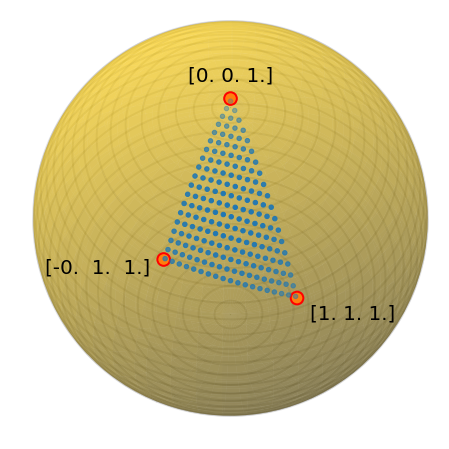

In [44]:
# Plot the zone axes included in the orientation plan
fig, ax = Au.plot_orientation_zones(
    plot_limit=np.array([-0.6, 0.6]),
    returnfig=True)

In [45]:
braggpeaks = datacube.bragg_positions['rotflip']

Best fit zone axis = ([-0.371 -0.622 -0.689]) with corr value = 12.445
Best fit zone axis = ([-0.219 -0.349 -0.911]) with corr value = 6.1


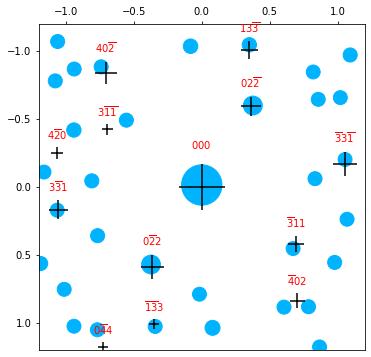

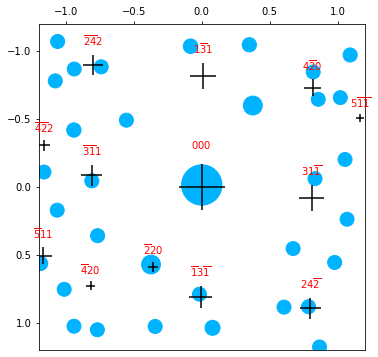

In [46]:
# Test matching on some probe positions
xind, yind = 5, 5
# xind, yind = 40, 35
# xind, yind = 50, 45
# xind, yind = 20, 5
# xind, yind = 52, 78

orient, corr_value = Au.match_single_pattern(
    braggpeaks.pointlists[xind][yind],
    num_matches_return=2,
    return_corr=True,
    plot_corr=False,
    subpixel_tilt=False,
    verbose=True,
)
bragg_peaks_fit_0 = Au.generate_diffraction_pattern(
    orient[:, :, 0], sigma_excitation_error=0.02
)
bragg_peaks_fit_1 = Au.generate_diffraction_pattern(
    orient[:, :, 1], sigma_excitation_error=0.02
)

# plot comparison
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_0,
    bragg_peaks_compare=braggpeaks.pointlists[xind][yind],
    scale_markers=50,
    scale_markers_compare=50,
    plot_range_kx_ky=np.array([1.2, 1.2]),
    min_marker_size=0.001,
    figsize=(6, 6),
)
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    bragg_peaks_fit_1,
    bragg_peaks_compare=braggpeaks.pointlists[xind][yind],
    scale_markers=50,
    scale_markers_compare=50,
    plot_range_kx_ky=np.array([1.2, 1.2]),
    min_marker_size=0.001,
    figsize=(6, 6),
)

In [ ]:
# Fit orientation to all probe positions
orientation_matrices, corr_all = Au.match_orientations(
    braggpeaks,
    return_corr=True,
    num_matches_return=2,
)

Matching Orientations:  52%|█████████████████████▏                   | 4330/8400 [02:14<02:20, 28.93 PointList/s]

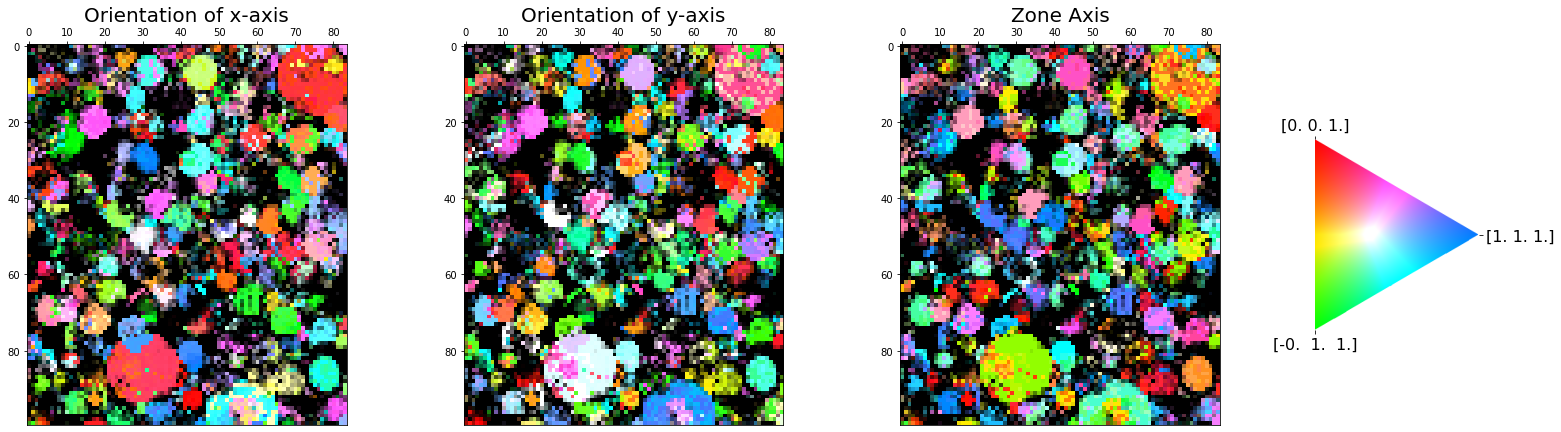

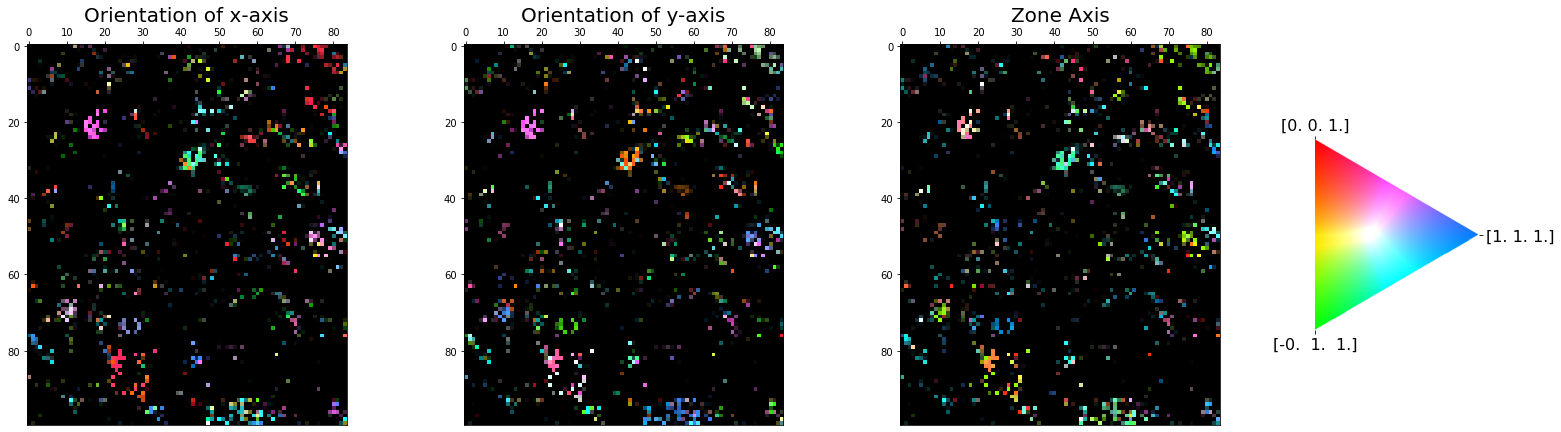

In [44]:
# plot maps from all of the matches
if orientation_matrices.ndim == 5:
    num_matches = orientation_matrices.shape[4]
else:
    num_matches = 1
for i in range(num_matches):
    Au.plot_orientation_maps(
        orientation_matrices,
        corr_all,
        orientation_index_plot=i,
        corr_normalize=False,
        corr_range=np.array([8,12]),
        scale_legend=np.array([0.45, 0.5]),
        returnfig=True,
        figsize=(30,7)
    )

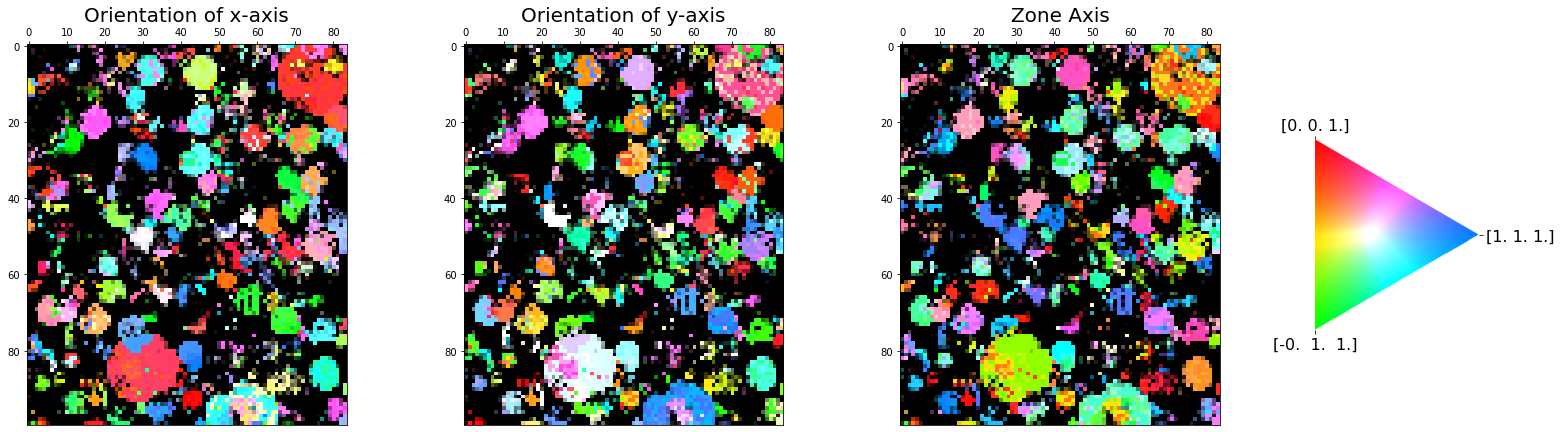

In [45]:
# plot orientation maps from one of the matches
images_orientation, fig, ax = Au.plot_orientation_maps(
    orientation_matrices,
    corr_all,
    orientation_index_plot=0,
    corr_normalize=False,
    corr_range=np.array([10, 12]),
    scale_legend=np.array([0.45, 0.5]),
    returnfig=True,
    figsize=(30, 7),
)

In [46]:
# Save the correlation outputs
# fig.savefig('ACOM_Au_sim.pdf')
fig.savefig('/Users/Ben/Desktop/ACOM_Au_sim.pdf')